# 🟥 Tarea

## Introducción

Si tenemos un etiquetado ground truth podemos usar métricas que comparan entre agrupamientos. Algunas de estas métricas suelen usarse en tareas de clustering. Algunos ejemplos son:

1. [Rand Index **RI**](https://scikit-learn.org/stable/modules/clustering.html#rand-index)
2. [Mutual Information based scores **MI**](https://scikit-learn.org/stable/modules/clustering.html#mutual-information-based-scores)
3. [Homogeneity, completeness and V-measure **HCV**](https://scikit-learn.org/stable/modules/clustering.html#homogeneity-completeness-and-v-measure)

## Ejercicios

Vamos a realizar la tarea de topic modeling usando el corpus `20newsgroups`

### 1. Usando LDA obten 20 tópicos, mide el desempeño usando una métrica de cada uno de los 3 grupos descritos anteriormentes (RI, MI, HCV). También mide el desempeño usando la coherencia.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn import metrics

from wordcloud import WordCloud

import spacy

from scipy.sparse import csr_matrix

from gensim import models, corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.matutils import Sparse2Corpus

Obtenemos los datos de entrenamiento y de prueba:

In [2]:
corpus = fetch_20newsgroups(subset='all', remove=('headers','footers','quotes'))

X = corpus.data

y = corpus.target
categories = corpus.target_names

Procesamos los documentos de entrenamiento para nuestro modelo:

In [3]:
nlp = spacy.blank('en')

tokenized_docs = [[t.text for t in tok_doc if
          not t.is_punct and \
          not t.is_space and \
          t.is_alpha] for tok_doc in nlp.pipe(X) ]

In [4]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(['said'])

In [5]:
tokenized_docs = [[w for w in doc if w not in stopwords] for doc in tokenized_docs]

In [6]:
docs = [" ".join(doc) for doc in tokenized_docs]

Creamos nuestro vectorizador y transformamos el corpus de entrenamiento:

In [7]:
vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=1000,
    smooth_idf=True
)

X_tfidf = vectorizer.fit_transform(docs)

In [8]:
X_tfidf.shape

(18846, 1000)

In [9]:
dicc = dict(zip(vectorizer.vocabulary_.values(),vectorizer.vocabulary_.keys()))
X_csc = csr_matrix(X_tfidf)

Entrenamos nuestro modelo LDA:

In [10]:
lda_model = models.LdaModel(
    corpus = Sparse2Corpus(X_csc, documents_columns=False), 
    num_topics = 20,
    id2word = dicc,
    random_state = 42
)

Usamos el modelo para predecir los temas del corpus:

In [11]:
dictionary = corpora.Dictionary.from_corpus(
    Sparse2Corpus(X_csc, documents_columns=False),
    id2word = dicc
)

bow = dictionary.doc2bow(tokenized_docs[0])
lda_model.get_document_topics(bow, minimum_probability=None)

[(4, 0.8899489), (6, 0.07790641)]

In [12]:
y_pred_lda = []

for doc in tokenized_docs:
    bow = dictionary.doc2bow(doc)
    topics = lda_model.get_document_topics(bow=bow, minimum_probability=None)
    topics = max(topics,key=lambda x: x[1])[0]
    y_pred_lda.append(topics)

Finalmente, podemos obtener las métricas RI, MI, HCV y Coherencia en nuestras predicciones:

In [13]:
def get_scores(y_true, y_pred):
    """
    Returns the Rand Index, Mutual Info and HCV Scores as a tuple
    """
    ri_score =  metrics.rand_score(y, y_pred)
    mi_score = metrics.mutual_info_score(y, y_pred)
    hcv_score = metrics.homogeneity_completeness_v_measure(y, y_pred)
    return ri_score, mi_score, hcv_score

In [14]:
ri_score, mi_score, hcv_score = get_scores(y, y_pred_lda)

In [15]:
cm = CoherenceModel(
    model = lda_model,
    corpus = Sparse2Corpus(X_csc, documents_columns=False),
    coherence = 'u_mass'
)

coherence = cm.get_coherence()

In [16]:
score_dict = {
    'metric': ['Rand Index', 'Mutual Info', 'Homogeneity','Completeness','V-measure', 'Coherence'],
    'score': [ri_score, mi_score, hcv_score[0], hcv_score[1], hcv_score[2], coherence]
}

In [17]:
score_df = pd.DataFrame(score_dict)
score_df

metric     score
0    Rand Index  0.885518
1   Mutual Info  0.590555
2   Homogeneity  0.197493
3  Completeness  0.221230
4     V-measure  0.208689
5     Coherence -2.469399

### 2. Usando LSA obten 20 tópicos, mide el desempeño usando una métrica de cada uno de los 3 grupos descritos anteriormentes (RI, MI, HCV). También mide el desempeño usando la coherencia.

Primero podemos inicializar un modelo SVD:

In [18]:
svd_model = TruncatedSVD(
    n_components = 20,
    algorithm = 'randomized',
    n_iter = 100,
    random_state = 42
)

svd_model.fit(X_tfidf)

TruncatedSVD(n_components=20, n_iter=100, random_state=42)

Una vez ajustado nuestro modelo, podemos obtener los topicos predecidos por el mismo para despues comparar con los labels reales:

In [19]:
y_pred_lsa = np.argmax(svd_model.transform(X_tfidf), axis=1)

Con las predicciones, podemos obtener las metricas para nuestro modelo:

In [20]:
ri_score, mi_score, hcv_score = get_scores(y, y_pred_lsa)

Para el caso de la coherencia, necesitamos calcularla manualmente:

In [21]:
def get_umass_score(dt_matrix, i, j):
    zo_matrix = (dt_matrix > 0).astype(int)
    col_i, col_j = zo_matrix[:, i], zo_matrix[:, j]
    col_ij = col_i + col_j
    col_ij = (col_ij == 2).astype(int)
    Di, Dij = col_i.sum(), col_ij.sum()
    return math.log((Dij + 1) / Di)

def get_topic_coherence(dt_matrix, topic, n_top_words):
    indexed_topic = zip(topic, range(0, len(topic)))
    topic_top = sorted(indexed_topic, key=lambda x: 1 - x[0])[0:n_top_words]
    coherence = 0
    for j_index in range(0, len(topic_top)):
        for i_index in range(0, j_index - 1):
            i = topic_top[i_index][1]
            j = topic_top[j_index][1]
            coherence += get_umass_score(dt_matrix, i, j)
    return coherence

def get_average_topic_coherence(dt_matrix, topics, n_top_words):
    total_coherence = 0
    for i in range(0, len(topics)):
        total_coherence += get_topic_coherence(dt_matrix, topics[i], n_top_words)
    return total_coherence / len(topics)

In [22]:
coherence = get_average_topic_coherence(X_tfidf, svd_model.components_, 10)

In [23]:
score_dict = {
    'metric': ['Rand Index', 'Mutual Info', 'Homogeneity','Completeness','V-measure', 'Coherence'],
    'score': [ri_score, mi_score, hcv_score[0], hcv_score[1], hcv_score[2], coherence]
}

In [24]:
score_df_lsa = pd.DataFrame(score_dict)
score_df_lsa

metric      score
0    Rand Index   0.490100
1   Mutual Info   0.272801
2   Homogeneity   0.091230
3  Completeness   0.194478
4     V-measure   0.124198
5     Coherence -88.508380

Podemos comparar mas facilmente las metricas de ambos modelos si unimos los dataframes con las metricas:

In [25]:
score_df_both = pd.merge(
    score_df_lsa,
    score_df,
    how = 'left',
    on = 'metric',
    suffixes = ('_lsa','_lda')
)

score_df_both

metric  score_lsa  score_lda
0    Rand Index   0.490100   0.885518
1   Mutual Info   0.272801   0.590555
2   Homogeneity   0.091230   0.197493
3  Completeness   0.194478   0.221230
4     V-measure   0.124198   0.208689
5     Coherence -88.508380  -2.469399

En la tabla anterior podemos apreciar que, excepto por la Homogeneidad, el modelo LDA se desempeñó mejoren todas las métricas que el modelo LSA.

### 3. Usando un algoritmo de clustering donde se especifique el número de clusters, obtener 20 clusters que, idealmente, representen los tópicos. El algoritmo de clustering lo aplicaras a las representaciones BOW o TF-IDF. Escoge la que mejor desempeño tenga de acuerdo a alguna de las métricas de los 3 grupos anteriores (RI, MI, HCV).

In [26]:
from sklearn.cluster import KMeans

Como ya tenemos un vector tfidf, usaremos ese primero:

In [27]:
kmeans_model = KMeans(
    n_clusters = 20,
    random_state = 42
)

In [28]:
kmeans_model.fit(X_tfidf)

KMeans(n_clusters=20, random_state=42)

In [29]:
y_pred_cluster_tfidf = kmeans_model.predict(X_tfidf)

In [30]:
ri_score, mi_score, hcv_score = get_scores(y, y_pred_cluster_tfidf)

score_df_kmeans_tfidf = pd.DataFrame({
    'metric': ['Rand Index', 'Mutual Info','Homogeneity','Completenes', 'V-measure'],
    'score': [ri_score, mi_score, hcv_score[0], hcv_score[1], hcv_score[2]]
})

In [31]:
score_df_kmeans_tfidf

metric     score
0   Rand Index  0.844481
1  Mutual Info  0.748222
2  Homogeneity  0.250220
3  Completenes  0.294032
4    V-measure  0.270362

Ahora realizamos el mismo procedimiento pero con un vector BoW:

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

In [33]:
bow = CountVectorizer(
    max_features = 1000,
    stop_words = 'english'
)

X_bow = bow.fit_transform(X)

Ahora, procedemos a entrenar un nuevo modelo KMeans con el nuevo vector BoW:

In [34]:
kmeans_model_bow = KMeans(
    n_clusters = 20,
    random_state = 42
)

In [35]:
y_pred_cluster_bow = kmeans_model_bow.fit_predict(X_bow)

In [36]:
ri_score, mi_score, hcv_score = get_scores(y, y_pred_cluster_bow)

score_df_kmeans_bow = pd.DataFrame({
    'metric': ['Rand Index', 'Mutual Info','Homogeneity','Completenes', 'V-measure'],
    'score': [ri_score, mi_score, hcv_score[0], hcv_score[1], hcv_score[2]]
})

In [37]:
score_df_kmeans_bow

metric     score
0   Rand Index  0.060825
1  Mutual Info  0.007998
2  Homogeneity  0.002675
3  Completenes  0.178419
4    V-measure  0.005270

Podemos unir los dataframes con las metricas para compararlos mas facilmente:

In [38]:
kmeans_scores = pd.merge(
    score_df_kmeans_tfidf,
    score_df_kmeans_bow,
    how = 'left',
    on = 'metric',
    suffixes = ('_tfidf', '_bow')
)

In [39]:
kmeans_scores

metric  score_tfidf  score_bow
0   Rand Index     0.844481   0.060825
1  Mutual Info     0.748222   0.007998
2  Homogeneity     0.250220   0.002675
3  Completenes     0.294032   0.178419
4    V-measure     0.270362   0.005270

En la tabla anterior podemos ver que el modelo con el vector Tfidf se desempeñó mejor que el vector BoW en todas las métricas, por lo que podemos concluir que el primero es el mejor para esta tarea.

### 4. En cada una de las 3 estrategias haz una exploración manual de algunos documentos, ¿parece haber coherencia?

In [40]:
docid_1 = 123
docid_2 = 20
docid_3 = 789

#### Modelo LDA

In [41]:
def explore_doc_topics_lda(docid, lda_model, model_dict, topn):
    doc = tokenized_docs[docid]
    print(X[docid])

    bow = model_dict.doc2bow(doc)
    topics = lda_model.get_document_topics(bow = bow, minimum_probability = None)
    doc_topic = max(topics, key = lambda x:x[1])[0]

    relevant_words = lda_model.show_topic(topicid=doc_topic, topn=10)

    print(f"Categoria del documento: {categories[y[docid]]}")
    print("\nPalabras relevantes del mismo topico:")
    for pair in relevant_words:
        print(pair[0], end=', ')

    return 

In [42]:
explore_doc_topics_lda(docid_1,lda_model,dictionary,10)


 >
 >: Thus, a deciBell (deci-, l., tenth of + Bell) is a fractional part of the
 >: original Bell.  For example, SouthWestern Bell is a deciBell.
 >
 >Out of what hat did you pull this one?  dB is a ratio not an RBOC!
 >
 >: And the measure of current, Amp, is actually named after both the AMP company
 >: and the Amphenol company.  Both companies revolutionized electronics by
 >: simulatenously realizing that the performance of connectors and sockets
 >: were affected by the amount of current running through the wires.
 >
 >Sorry.  The unit for current is the AMPERE which is the name of a french-man
 >named AMPERE who studied electrical current.  The term AMP is just an abbreviation
 >of it.  The company AMP came after the AMPERE unit was already in use.
 >
 >: The Ohmite company was the first to characterize resistances by numbers,
 >: thus our use of the Ohms...
 >
 >I don't know about this one, but it doesn't sound right.
 >
 >:
 >: Alexander Graham Bell, actually, is where Bell c

In [43]:
explore_doc_topics_lda(docid_2, lda_model, dictionary, 10)

: 
: I am considering buying a 1993 Chevy or GMC 4x4 full-size pickup with
: the extended cab.  Any opinions about these vehicles?  Have there been
: any significant problems?
: 
: -- 
: Dick Grady           Salem, NH,  USA            grady@world.std.com
: So many newsgroups, so little time!


I bought a brand new 1992 Chevrolet K2500 HD 4x4 extended cab last
May.  It has had many, many problems.  See my earler post that describes
the situation.  I went to BBB arbitration, and they ruled that Chevrolet
must buy it back from me.  If you do get one, stay away from the 5 speed
manual with the deep low first gear.  They have put three of them in my
truck so far.  After about 1,500 miles, overdrive either starts
rattling or hissing loudly.  There is no way to fix them.  Chevrolet 
says that the noise is "a characteristic of the transmission."

Also, if you are planning to use your truck to tow, the
gear ratios in that tranny suck.  On a steep hill, you get up to about
55 MPH in second gear 

In [44]:
explore_doc_topics_lda(docid_3, lda_model, dictionary, 10)

I have a mac plus with 2.5MB RAM. I have just bought an extra 2MB so that
I can have the max 4MB RAM that a plus supports. However, I can't get it
to boot after I install the 2 extra SIMMs. Instead I get a sad mac (Sorry,
but I can't remember the code). Looking at the motherboard, I can see
that 2 resistors have been snipped off where it says "256Kb path -
1 row". I assume that was done when the first 1MB SIMMs were added.

So, my question is: Are there any other resistors that need snipping? 
				or, Do I have bum SIMMs which need to be exchanged?

Any and all advice will be appreciated.
Categoria del documento: comp.sys.mac.hardware

Palabras relevantes del mismo topico:
drive, card, mb, disk, mac, scsi, drives, driver, hard, cpu, 

En este caso, parece que si hay una coherencia entre los documentos y los términos asociados al mismo tópico que el documento, en el primer caso, vemos que el documento habla sobre diversas unidades relacionadas con la electricidad, y los términos relevantes del mismo topico al que fue asignado parecen hacer referencia a cosas similares. Lo mismo pasa en el segundo documento, que habla de carros, y el tercero, que habla de informatica y computadoras Mac.

#### Modelo LSA

In [45]:
def explore_doc_topics_lsa(docid: int, lsa_model, vectorizer, topn: int):
    doc_vector = X_tfidf[docid]
    topic = np.argmax(lsa_model.transform(doc_vector), axis=1)[0]

    comp = lsa_model.components_[topic]
    terms = vectorizer.get_feature_names_out()

    terms_comp = zip(terms,comp)
    sorted_terms = sorted(terms_comp, key=lambda x:x[1], reverse=True)[:topn]

    print("Documento:")
    print(X[docid])

    print(f"Categoria del documento: {categories[y[docid]]}")
    print("\nTerminos relacionados del mismo topico:")
    for t in sorted_terms:
        print(t[0], end=', ')

    return

In [46]:
explore_doc_topics_lsa(docid_1, svd_model, vectorizer, 10)

Documento:

 >
 >: Thus, a deciBell (deci-, l., tenth of + Bell) is a fractional part of the
 >: original Bell.  For example, SouthWestern Bell is a deciBell.
 >
 >Out of what hat did you pull this one?  dB is a ratio not an RBOC!
 >
 >: And the measure of current, Amp, is actually named after both the AMP company
 >: and the Amphenol company.  Both companies revolutionized electronics by
 >: simulatenously realizing that the performance of connectors and sockets
 >: were affected by the amount of current running through the wires.
 >
 >Sorry.  The unit for current is the AMPERE which is the name of a french-man
 >named AMPERE who studied electrical current.  The term AMP is just an abbreviation
 >of it.  The company AMP came after the AMPERE unit was already in use.
 >
 >: The Ohmite company was the first to characterize resistances by numbers,
 >: thus our use of the Ohms...
 >
 >I don't know about this one, but it doesn't sound right.
 >
 >:
 >: Alexander Graham Bell, actually, is w

In [47]:
explore_doc_topics_lsa(docid_2, svd_model, vectorizer, 10)

Documento:
: 
: I am considering buying a 1993 Chevy or GMC 4x4 full-size pickup with
: the extended cab.  Any opinions about these vehicles?  Have there been
: any significant problems?
: 
: -- 
: Dick Grady           Salem, NH,  USA            grady@world.std.com
: So many newsgroups, so little time!


I bought a brand new 1992 Chevrolet K2500 HD 4x4 extended cab last
May.  It has had many, many problems.  See my earler post that describes
the situation.  I went to BBB arbitration, and they ruled that Chevrolet
must buy it back from me.  If you do get one, stay away from the 5 speed
manual with the deep low first gear.  They have put three of them in my
truck so far.  After about 1,500 miles, overdrive either starts
rattling or hissing loudly.  There is no way to fix them.  Chevrolet 
says that the noise is "a characteristic of the transmission."

Also, if you are planning to use your truck to tow, the
gear ratios in that tranny suck.  On a steep hill, you get up to about
55 MPH in s

In [48]:
explore_doc_topics_lsa(docid_3, svd_model, vectorizer, 10)

Documento:
I have a mac plus with 2.5MB RAM. I have just bought an extra 2MB so that
I can have the max 4MB RAM that a plus supports. However, I can't get it
to boot after I install the 2 extra SIMMs. Instead I get a sad mac (Sorry,
but I can't remember the code). Looking at the motherboard, I can see
that 2 resistors have been snipped off where it says "256Kb path -
1 row". I assume that was done when the first 1MB SIMMs were added.

So, my question is: Are there any other resistors that need snipping? 
				or, Do I have bum SIMMs which need to be exchanged?

Any and all advice will be appreciated.
Categoria del documento: comp.sys.mac.hardware

Terminos relacionados del mismo topico:
like, know, people, think, time, good, use, new, way, thanks, 

En este caso, no parece haber mucha coherencia, ya que segun los términos relacionados, parece que los 3 documentos fueron clasificados de la misma forma, a pesar de pertenecer a categorías diferentes.

#### Modelo de Clustering

In [50]:
def explore_doc_topics_clustering(docid, model, topn):

    doc_vector = X_tfidf[docid]
    doc_topic = model.predict(doc_vector)

    docs_idxs = [np.where(y_pred_cluster_tfidf == doc_topic[0])]
    print(X[docid])

    print(f"Categoria del documento: {categories[y[docid]]}")
    print("\nTerminos mas frecuentes en el mismo topico/cluster:")

    topic_docs = " ".join([docs[i] for i in docs_idxs[0][0]])
    wc =  WordCloud(background_color="white", max_words=2000).generate(topic_docs)
    
    for word in list(wc.words_.keys())[:topn]:
        print(word, end=', ')

    return

In [51]:
explore_doc_topics_clustering(docid_1, kmeans_model, 10)

Topico original del documento: sci.electronics

 >
 >: Thus, a deciBell (deci-, l., tenth of + Bell) is a fractional part of the
 >: original Bell.  For example, SouthWestern Bell is a deciBell.
 >
 >Out of what hat did you pull this one?  dB is a ratio not an RBOC!
 >
 >: And the measure of current, Amp, is actually named after both the AMP company
 >: and the Amphenol company.  Both companies revolutionized electronics by
 >: simulatenously realizing that the performance of connectors and sockets
 >: were affected by the amount of current running through the wires.
 >
 >Sorry.  The unit for current is the AMPERE which is the name of a french-man
 >named AMPERE who studied electrical current.  The term AMP is just an abbreviation
 >of it.  The company AMP came after the AMPERE unit was already in use.
 >
 >: The Ohmite company was the first to characterize resistances by numbers,
 >: thus our use of the Ohms...
 >
 >I don't know about this one, but it doesn't sound right.
 >
 >:
 >: A

In [52]:
explore_doc_topics_clustering(docid_2, kmeans_model, 10)

Topico original del documento: rec.autos
: 
: I am considering buying a 1993 Chevy or GMC 4x4 full-size pickup with
: the extended cab.  Any opinions about these vehicles?  Have there been
: any significant problems?
: 
: -- 
: Dick Grady           Salem, NH,  USA            grady@world.std.com
: So many newsgroups, so little time!


I bought a brand new 1992 Chevrolet K2500 HD 4x4 extended cab last
May.  It has had many, many problems.  See my earler post that describes
the situation.  I went to BBB arbitration, and they ruled that Chevrolet
must buy it back from me.  If you do get one, stay away from the 5 speed
manual with the deep low first gear.  They have put three of them in my
truck so far.  After about 1,500 miles, overdrive either starts
rattling or hissing loudly.  There is no way to fix them.  Chevrolet 
says that the noise is "a characteristic of the transmission."

Also, if you are planning to use your truck to tow, the
gear ratios in that tranny suck.  On a steep hill, y

In [53]:
explore_doc_topics_clustering(docid_3, kmeans_model, 10)

Topico original del documento: comp.sys.mac.hardware
I have a mac plus with 2.5MB RAM. I have just bought an extra 2MB so that
I can have the max 4MB RAM that a plus supports. However, I can't get it
to boot after I install the 2 extra SIMMs. Instead I get a sad mac (Sorry,
but I can't remember the code). Looking at the motherboard, I can see
that 2 resistors have been snipped off where it says "256Kb path -
1 row". I assume that was done when the first 1MB SIMMs were added.

So, my question is: Are there any other resistors that need snipping? 
				or, Do I have bum SIMMs which need to be exchanged?

Any and all advice will be appreciated.
Categoria del documento: comp.sys.mac.hardware

Terminos mas frecuentes en el mismo topico/cluster:
one, know, Q, DB DB, may, say, well, u, time, new, 

Si bien en este caso los 3 documentos parecen haber sido agrupados en diferentes categorías, los términos relevantes parecen ser palabras muy generales o que no aportan un significado importante para el tópico, por lo que no parece ser un clustering muy útil o coherente.

### 5. En cada una de las 3 estrategias haz una nube de palabras por cada tópico, ¿parece haber coherencia en el vocabulario?

#### Modelo LDA

In [54]:
y_pred = []

for doc in tokenized_docs:
    bow = dictionary.doc2bow(doc)
    topics = lda_model.get_document_topics(bow=bow, minimum_probability=None)
    topic = max(topics,key=lambda x: x[1])[0]
    # print(sorted(topics,key=lambda x: x[1]))
    # print(topic)
    y_pred.append(topic)

y_pred = np.array(y_pred)

/tmp/ipykernel_9996/2737382204.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


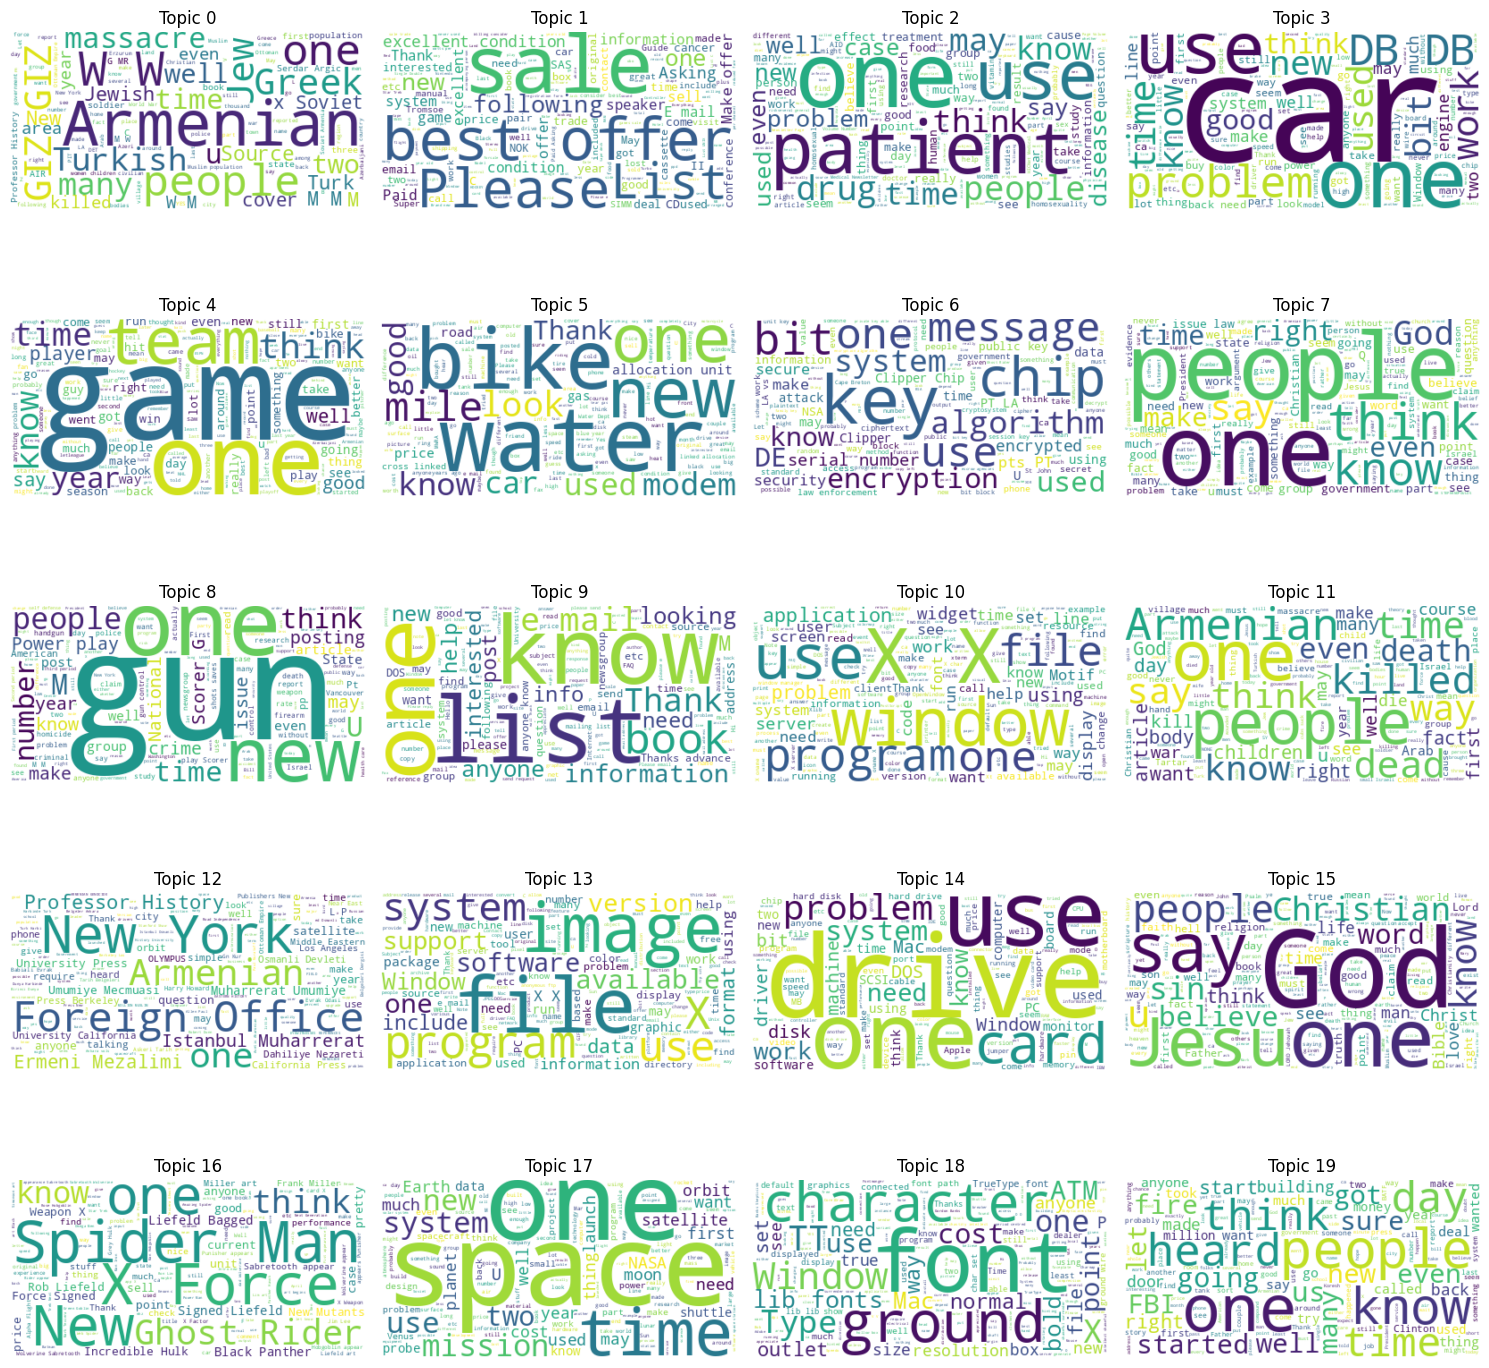

In [55]:
num_topics = len(np.unique(y_pred))

docs_idxs_per_topic = [np.where(y_pred == i)[0] for i in range(num_topics)]

fig, axs = plt.subplots(5, 4, figsize=(15, 15))
for ax,j in zip(axs.flatten(),range(num_topics)):
    topic_docs = " ".join([docs[i] for i in docs_idxs_per_topic[j]])
    wc = WordCloud(background_color="white", max_words=2000).generate(topic_docs)
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(f"Topic {j}")
    ax.axis("off")
fig.tight_layout()
fig.show()

En este caso, parece haber una buena coherencia en los vocabularios de los tópicos, podemos por ejemplo inferir que el tópico 17 agrupa palabras o documentos relacionados con el espacio, el 16 temas relacionados con ciencia ficción o super heroes, o el tópico 3 que parece hablar de carros, entre otros.

#### Modelo LSA

/tmp/ipykernel_9996/3375121208.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


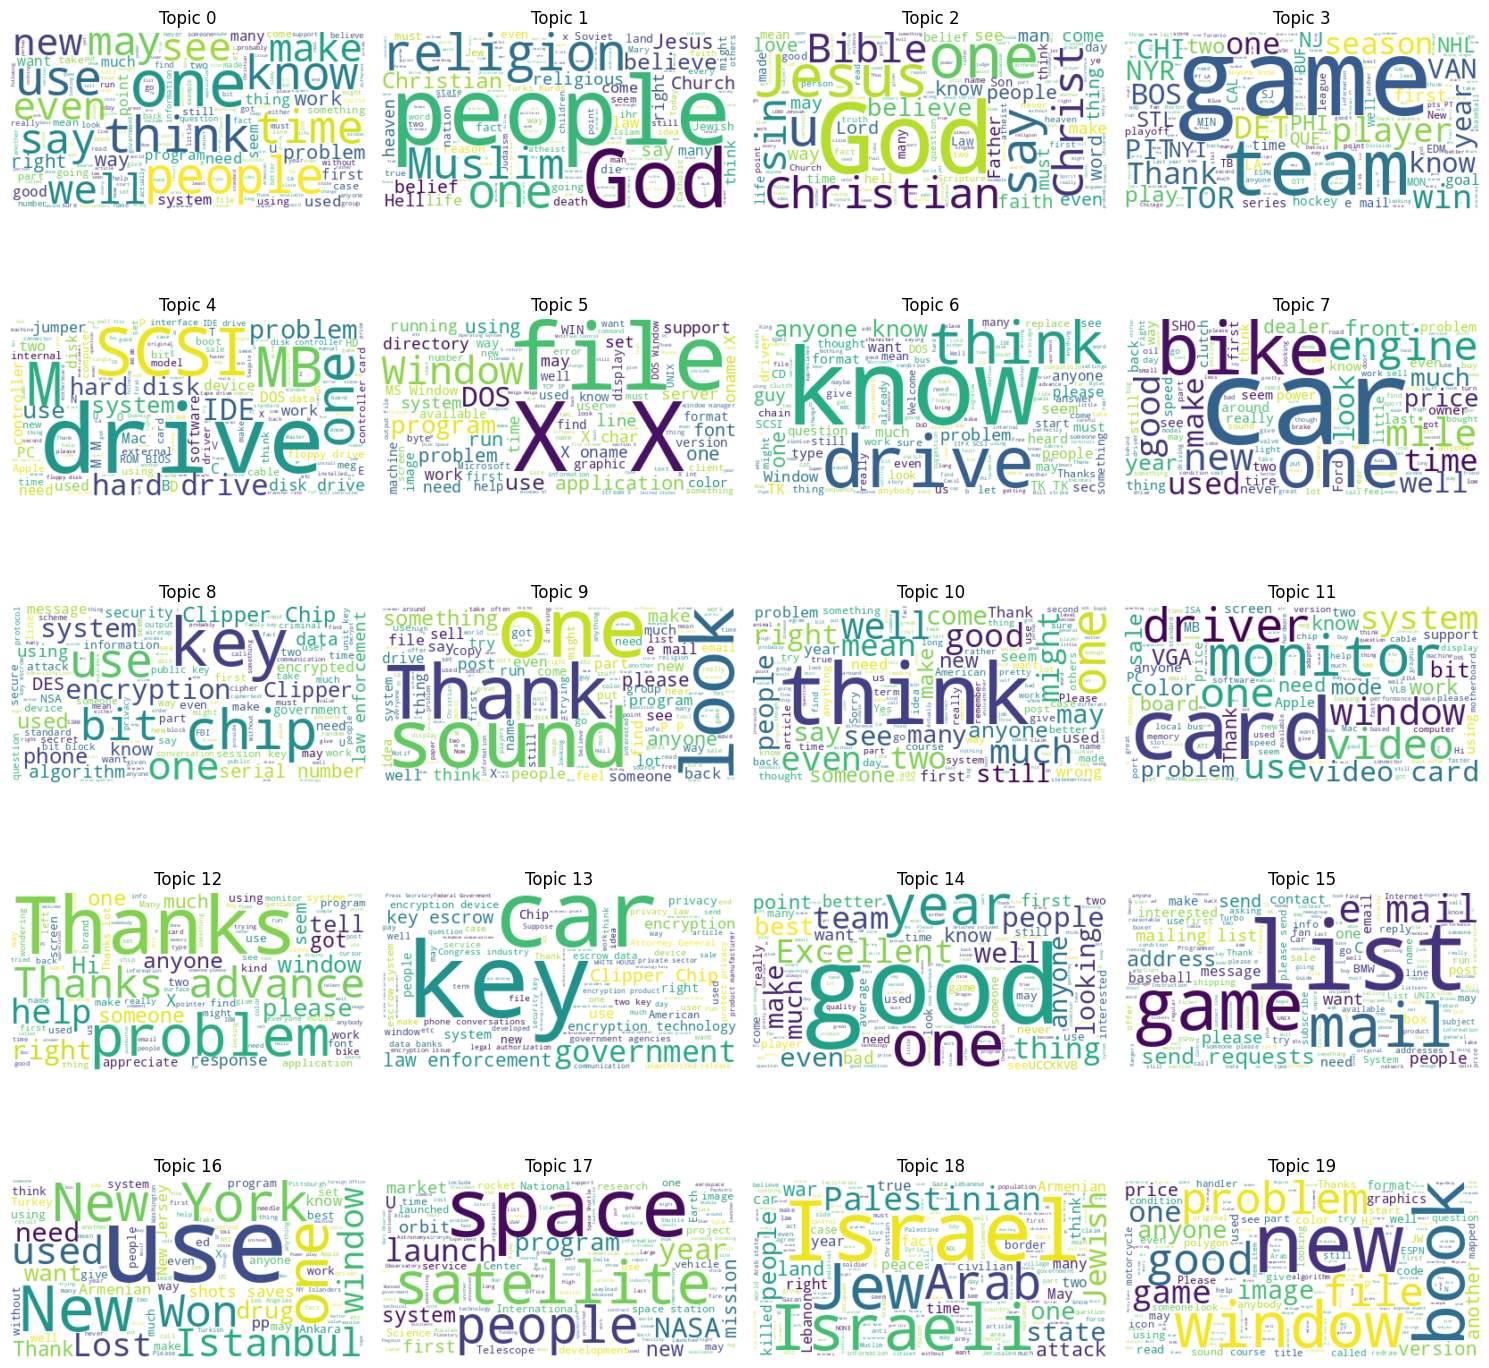

In [56]:
topics = np.argmax(svd_model.transform(X_tfidf), axis=1)
num_topics = len(np.unique(topics))

docs_idxs_per_topic = [np.where(topics == i)[0] for i in range(num_topics)]

fig, axs = plt.subplots(5, 4, figsize=(15, 15))
for ax,j in zip(axs.flatten(),range(num_topics)):
    topic_docs = " ".join([docs[i] for i in docs_idxs_per_topic[j]])
    wc = WordCloud(background_color="white", max_words=2000).generate(topic_docs)
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(f"Topic {j}")
    ax.axis("off")
fig.tight_layout()
fig.show()

Si bien aqui tambien parece haber coherencia en los vocabularios de algunos tópicos, como el 18, el 17 o el 4, algunos otros parecen no tener una buena coherencia, ya que agrupan terminos muy generales, como es el caso del 19, el 14 o el 6.

#### Modelo de Clustering

/tmp/ipykernel_9996/467275165.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


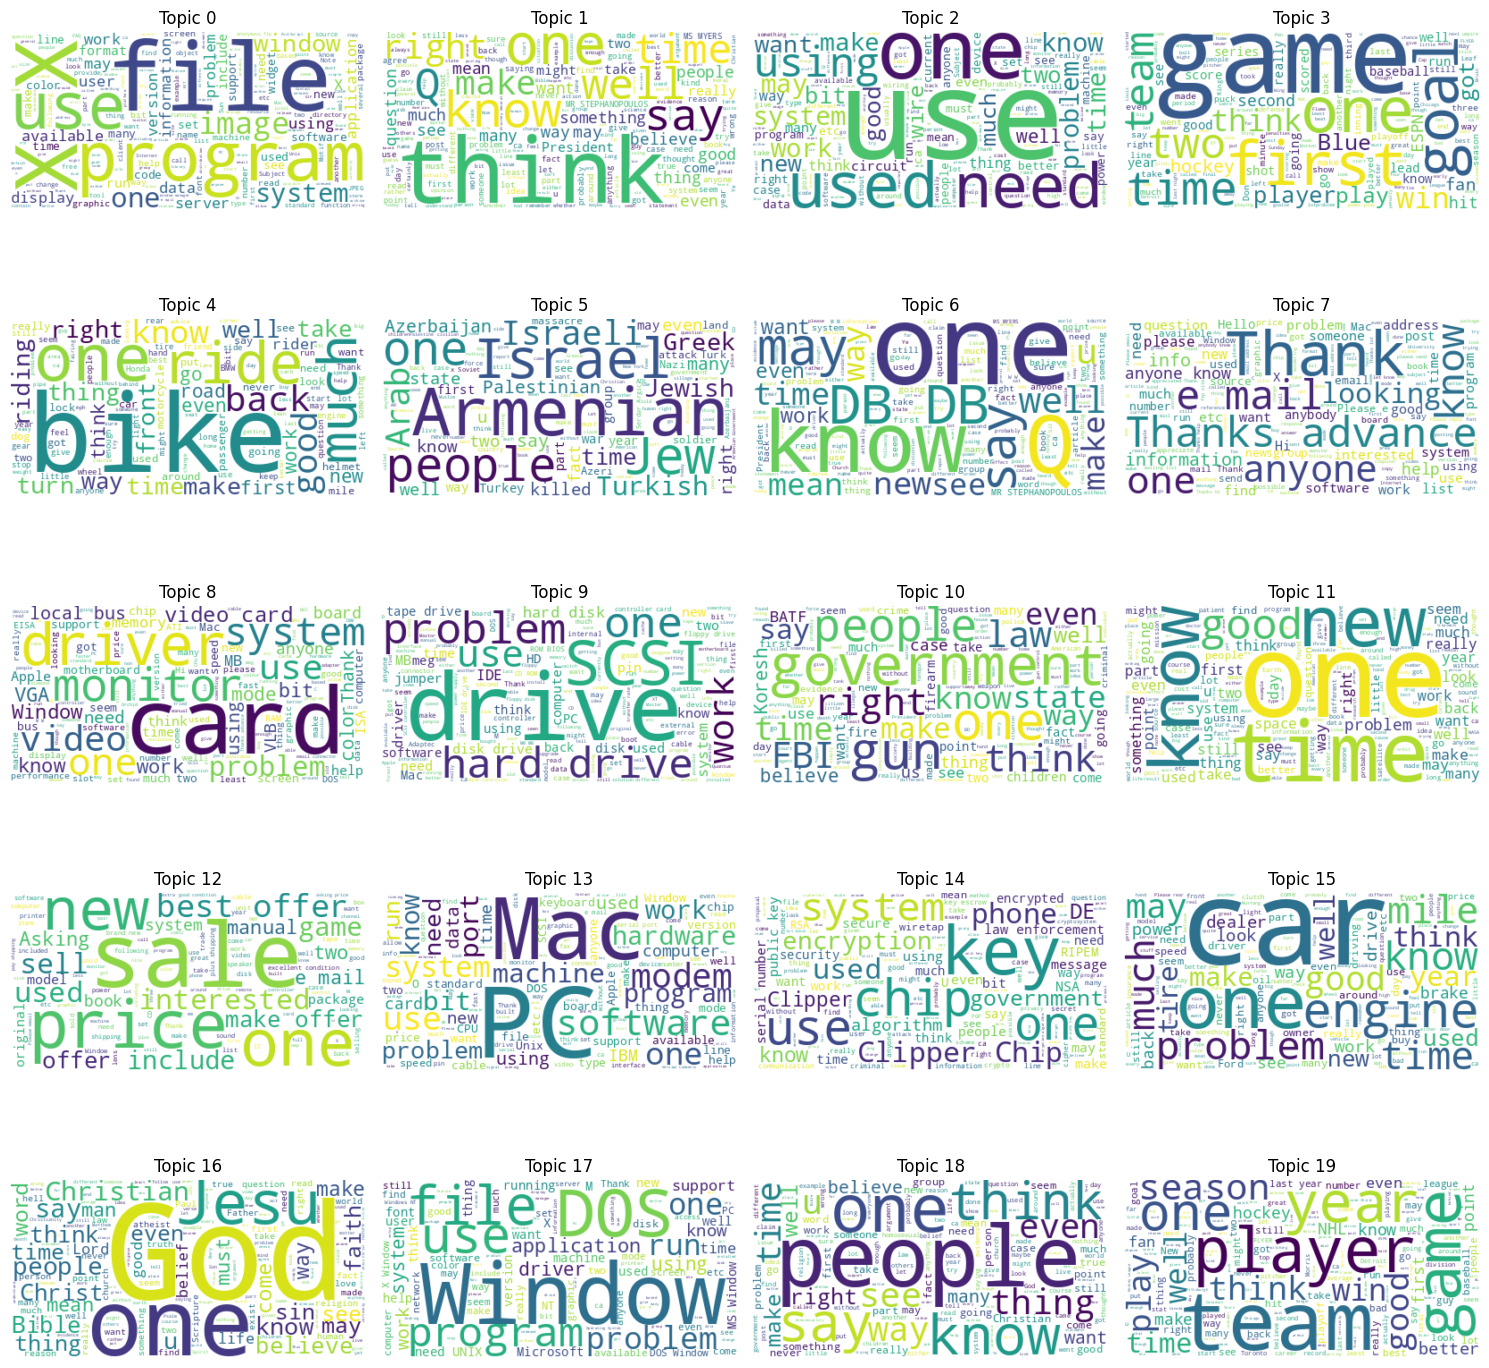

In [57]:
topics = kmeans_model.predict(X_tfidf)
num_topics = len(np.unique(topics))

docs_idxs_per_topic = [np.where(topics == i)[0] for i in range(num_topics)]

fig, axs = plt.subplots(5, 4, figsize=(15, 15))
for ax,j in zip(axs.flatten(),range(num_topics)):
    topic_docs = " ".join([docs[i] for i in docs_idxs_per_topic[j]])
    wc = WordCloud(background_color="white", max_words=2000).generate(topic_docs)
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(f"Topic {j}")
    ax.axis("off")
fig.tight_layout()
fig.show()

Este caso parece ser bastante similar al anterior, ya que varios tópicos no muestran mucha coherencia en su vocabulario, agrupando términos muy generales o ambigüos.

---

### 6. Con el mismo corpus obten el mejor número de tópicos usando LSA de acuerdo a las métricas:
 * Coherencia.
 * Alguna de los grupos RI, MI, HCV.
 * Coherencia usando la similitud coseno entre embeddings.

Para poder obtener la coherencia utilizando similitud coseno entre embeddings, primero debemos utilizar un modelo que obtenga estos embeddings, en este caso, utilizamos el modelo `FastText` de gensim:

In [58]:
from gensim.models import FastText

fasttext_model = FastText(sentences=tokenized_docs, vector_size=100, window=5, min_count=2, workers=4)

Ahora definimos una funcion para calcular la similitud coseno entre los diferentes pares de vectores, y obtener el promedio de la misma a traves de todos los topicos:

In [59]:
def get_avg_cosine_coherence_lsa(lsa_model, vectorizer_model, tfidf_vectorizer):
    feature_names = tfidf_vectorizer.get_feature_names_out()

    top_words_per_topic = []
    for i, topic in enumerate(lsa_model.components_):
        # Get the top N words for each topic
        top_words = [feature_names[j] for j in topic.argsort()[-10:][::-1]]
        top_words_per_topic.append(top_words)
    
    topic_coherences = [topic_coherence_fasttext_similarity(words, vectorizer_model) for words in top_words_per_topic]

    average_topic_coherence = np.mean(topic_coherences)

    return average_topic_coherence



def topic_coherence_fasttext_similarity(topic_words, fasttext_model):
    word_vectors = [fasttext_model.wv[word] for word in topic_words if word in fasttext_model.wv]
    if len(word_vectors) < 2:
        return 0  # Skip if not enough vectors

    # Calculate pairwise cosine similarity and compute coherence as average similarity
    similarities = metrics.pairwise.cosine_similarity(word_vectors)
    num_pairs = len(word_vectors) * (len(word_vectors) - 1) / 2
    coherence = np.sum(np.triu(similarities, k=1)) / num_pairs
    return coherence

Finalmente, iteramos para diferentes valores de componentes $k$ para el modelo LSA y obtener un promedio de las metricas para cada $k$.

In [60]:
num_topics = [3+k for k in range(20)]
coherences_lsa = []
homogeneity_scores_lsa = []
cosine_coherences_lsa = []

for k in num_topics:
    svd_model = TruncatedSVD(
        n_components = k,
        algorithm = 'randomized',
        n_iter = 100,
        random_state = 42
    )

    svd_model.fit(X_tfidf)

    coherence = get_average_topic_coherence(X_tfidf, svd_model.components_, 10)
    coherences_lsa.append(coherence)

    y_pred = np.argmax(svd_model.transform(X_tfidf), axis=1)

    homogeneity_scores_lsa.append(metrics.homogeneity_completeness_v_measure(y, y_pred)[0])

    cosine_coherences_lsa.append(get_avg_cosine_coherence_lsa(svd_model, fasttext_model, vectorizer))

Una vez obtenidos los valores, podemos graficar cada metrica en funcion del numero de componentes del modelo:

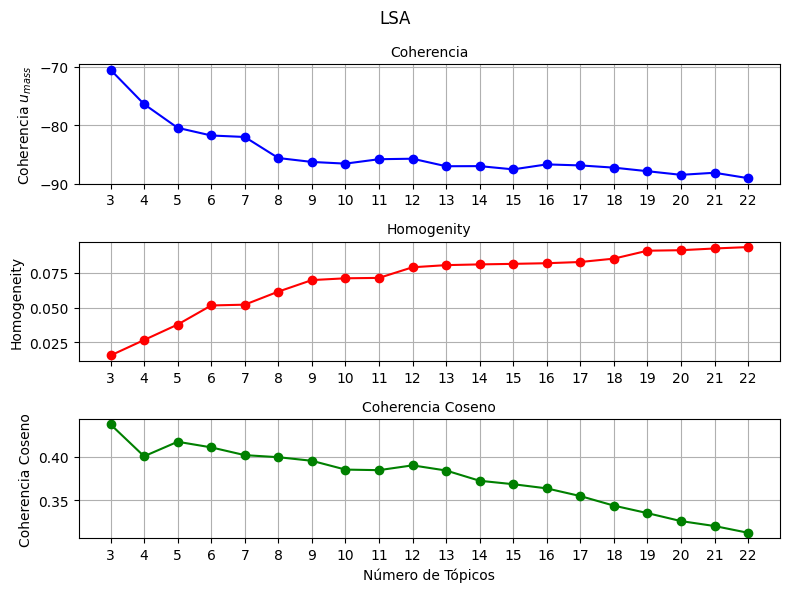

In [61]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(8, 6))

# Gráfico de coherencia
ax1.plot(num_topics, coherences_lsa, marker='o', color='blue')
ax1.set_title('Coherencia', fontsize=10)
ax1.set_ylabel(r'Coherencia $u_{mass}$')
ax1.set_xticks(num_topics)
ax1.grid()

# Gráfico de Homogeneidad
ax2.plot(num_topics, homogeneity_scores_lsa, marker='o', color='red', label='AMI')
ax2.set_title('Homogenity', fontsize=10)
ax2.set_ylabel('Homogeneity')
ax2.set_xticks(num_topics)
ax2.grid()

# Gráfico de coherencia coseno
ax3.plot(num_topics, cosine_coherences_lsa, marker='o', color='green', label='Coherencia Coseno')
ax3.set_title('Coherencia Coseno', fontsize=10)
ax3.set_xlabel('Número de Tópicos')
ax3.set_ylabel('Coherencia Coseno')
ax3.set_xticks(num_topics)
ax3.grid()

plt.suptitle("LSA")
plt.tight_layout()
plt.show()

En este caso, vemos que todas las metricas (Coherencia u_mass, Homogeneidad y Coherencia con similitud coseno), disminuyen conforme aumenta el numero de topico $k$.

### 7. Con el mismo corpus obten el mejor número de tópicos usando LDA de acuerdo a las métricas:
 * Coherencia.
 * Alguna de los grupos RI, MI, HCV.
 * Coherencia usando la similitud coseno entre embeddings.

In [62]:
def get_avg_cosine_coherence_lda(lda_model, vectorizer_model):

    top_words_per_topic = []
    for t in range(lda_model.num_topics):
        top_words = [word for word, _ in lda_model.show_topic(t, topn=10)]
        top_words_per_topic.append(top_words)
    
    topic_coherences = [topic_coherence_fasttext_similarity(words, vectorizer_model) for words in top_words_per_topic]

    average_topic_coherence = np.mean(topic_coherences)

    return average_topic_coherence

In [63]:
num_topics = [3+k for k in range(20)]
coherences_lda = []
homogeneity_scores_lda = []
cosine_coherences_lda = []

for k in num_topics:
    lda_model = models.LdaModel(corpus=Sparse2Corpus(X_csc,documents_columns=False),
                                num_topics=k, id2word=dicc, random_state=42)
    cm = CoherenceModel(model=lda_model,
                    coherence='u_mass',
                    corpus=Sparse2Corpus(X_csc,documents_columns=False),
                    )
    coherences_lda.append(cm.get_coherence())

    y_pred = []
    for doc in tokenized_docs:
        bow = dictionary.doc2bow(doc)
        topics = lda_model.get_document_topics(bow=bow, minimum_probability=None)
        topics = max(topics,key=lambda x: x[1])[0]
        y_pred.append(topics)
    
    homogeneity_scores_lda.append(metrics.homogeneity_completeness_v_measure(y, y_pred)[0])

    cosine_coherences_lda.append(get_avg_cosine_coherence_lda(lda_model, fasttext_model))

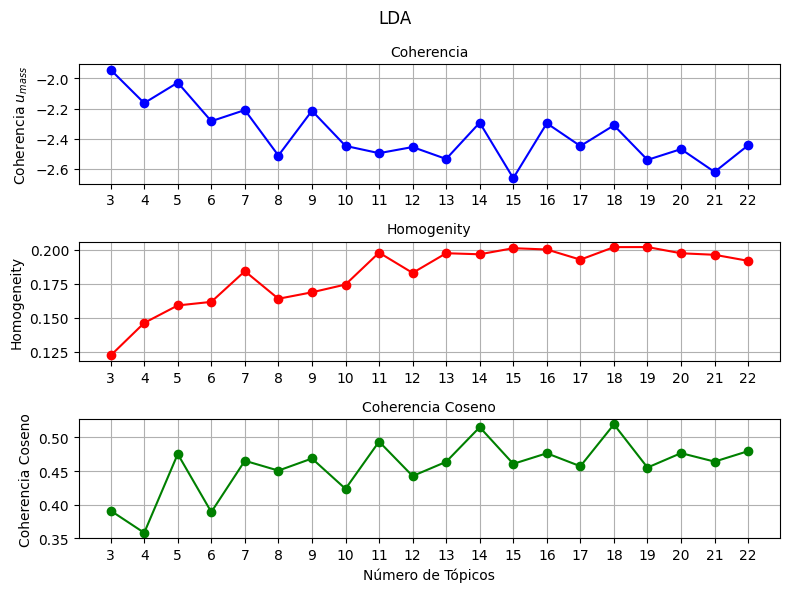

In [64]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(8, 6))

# Gráfico de coherencia
ax1.plot(num_topics, coherences_lda, marker='o', color='blue')
ax1.set_title('Coherencia', fontsize=10)
ax1.set_ylabel(r'Coherencia $u_{mass}$')
ax1.set_xticks(num_topics)
ax1.grid()

# Gráfico de Homogeneidad
ax2.plot(num_topics, homogeneity_scores_lda, marker='o', color='red', label='AMI')
ax2.set_title('Homogenity', fontsize=10)
ax2.set_ylabel('Homogeneity')
ax2.set_xticks(num_topics)
ax2.grid()

# Gráfico de coherencia coseno
ax3.plot(num_topics, cosine_coherences_lda, marker='o', color='green', label='Coherencia Coseno')
ax3.set_title('Coherencia Coseno', fontsize=10)
ax3.set_xlabel('Número de Tópicos')
ax3.set_ylabel('Coherencia Coseno')
ax3.set_xticks(num_topics)
ax3.grid()

plt.suptitle("LDA")
plt.tight_layout()
plt.show()

## Conclusiones

Redacta un pequeño texto respondiendo las siguientes preguntas.

* ¿Cuál método te parece *mejor* en este corpus?
* El hecho de tener las etiquetas reales de tópicos, ¿facilita la tarea?
* ¿Las diferentes métricas parecen ser coherentes entre ellas?

Después de trabajar un poco más con los diferentes tipos de modelos aplicables en este caso, me parece que para este corpus, el modelo LDA es el que mejor se desempeñó con este corpus. 

El haber tenido las etiquetas reales de los tópicos definitivamente facilitó la tarea, ya que se tenía una "verdad base" para poder comparar más directamente el desempeño de cada uno. Sin embargo, esto también pudo haber ocasionado un "sesgo" hacía el modelo LDA, ya que este parece haber agrupado los tópicos de forma similar a las etiquetas originales, lo que puede causar inconscientemente una preferencia hacia éste.

En cuanto a las métricas, parece que si hay una coherencia entre ellas, sobre todo en el último punto de esta tarea. En éste, vemos como el modelo LDA se desempeñó de forma muy superior al LSA. Vemos como el primero (LDA) no solamente obtuvo una mayor coherencia u_mass y de coseno para todos los valores de tópicos, sino que también aumentó ésta última conforme aumentaba el número de tópicos, cosa que no ocurrió con el modelo LSA. Si bien el módelo LSA parece haber obtenido un mejor puntaje de Homogeneidad, esto por si solo no es muy útil si las diferentes clases predichas no presentan una coherencia entre ellas.